# Dow Jones Industrial Average Index Predictor

* This application can be used to predict the prices for any stock.
  * In this example, we use the Dow Jones Industrial Average Index
### Imports

In [3]:
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
import yfinance as yf
from tickers import *
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.utils import plot_model
from datetime import datetime

### DIJA History

In [22]:
dija_history = yf.Ticker('DJI').history(period = 'max', interval = '1d')
dija_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1970-01-02 00:00:00-05:00,809.200012,809.200012,809.200012,809.200012,0,0.0,0.0
1970-01-05 00:00:00-05:00,811.309998,811.309998,811.309998,811.309998,0,0.0,0.0
1970-01-06 00:00:00-05:00,803.659973,803.659973,803.659973,803.659973,0,0.0,0.0
1970-01-07 00:00:00-05:00,801.809998,801.809998,801.809998,801.809998,0,0.0,0.0
1970-01-08 00:00:00-05:00,802.070007,802.070007,802.070007,802.070007,0,0.0,0.0
...,...,...,...,...,...,...,...
2022-02-24 00:00:00-05:00,33223.800781,33223.800781,33223.800781,33223.800781,0,0.0,0.0
2022-02-25 00:00:00-05:00,34058.800781,34058.800781,34058.800781,34058.800781,0,0.0,0.0
2022-02-28 00:00:00-05:00,33892.601562,33892.601562,33892.601562,33892.601562,0,0.0,0.0


### Drop Unused Columns

In [23]:
dija_history = dija_history.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Stock Splits'])
dija_history

,Close,Dividends
Date,,
1970-01-02 00:00:00-05:00,809.200012,0.0
1970-01-05 00:00:00-05:00,811.309998,0.0
1970-01-06 00:00:00-05:00,803.659973,0.0
1970-01-07 00:00:00-05:00,801.809998,0.0
1970-01-08 00:00:00-05:00,802.070007,0.0
...,...,...
2022-02-24 00:00:00-05:00,33223.800781,0.0
2022-02-25 00:00:00-05:00,34058.800781,0.0
2022-02-28 00:00:00-05:00,33892.601562,0.0


* Noting min and max for denormalization later on.

In [24]:
h_min = dija_history['Close'].min()
h_max = dija_history['Close'].max()
print(h_min, h_max)

577.5999755859375 36799.69921875


### Plot of Index

Text(0, 0.5, 'Close')

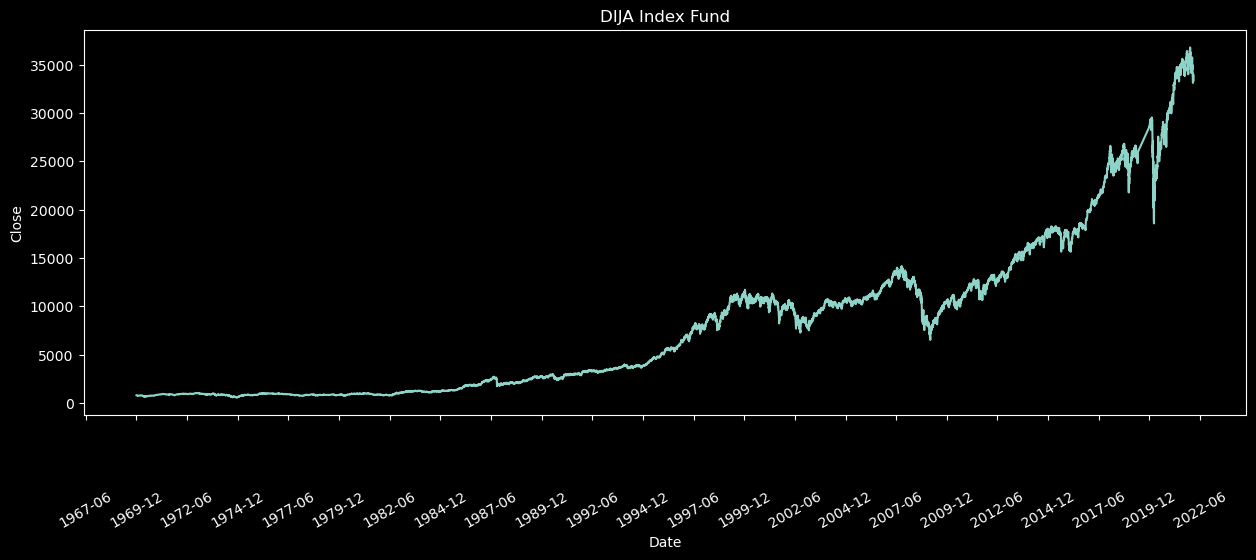

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(dija_history.index, dija_history['Close'])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=30))
ax.xaxis.set_tick_params(rotation=30, which = 'major', pad = 50)
ax.set_title(f"DIJA Index Fund")
ax.set_xlabel("Date")
ax.set_ylabel("Close")

### Generate Inputs and Targets
* Use $x$ days for input to predict the $x + 1$'th day of the DIJA Index

In [8]:
"""
data - Dataset to be processed
value_num - number of input values the series should have
"""
def generate_series(data, value_num):
    close = data['Close']
    dividends = data['Dividends']
    tsg = TimeseriesGenerator(close, close, length= value_num, batch_size = len(close))
    global_index = value_num
    i, t = tsg[0]
    has_dividends = np.zeros(len(i))
    for b_row in range(len(t)):
        assert(abs(t[b_row] - close[global_index]) <= 0.001)
        has_dividends[b_row] = dividends[global_index] > 0
        global_index += 1

    return np.concatenate((i, np.transpose([has_dividends])), axis = 1), t

### Normalization

$$Normalize(x_i) = \frac{x_i - min(x)}{max(x) - min(x)}$$

* Neural networks do not perform well with large ranges of inputs, so we will use min-max normalization

* Only the close price will be normalized

In [9]:
def normalize_data(history):
    close_col = history['Close']  # Extract the "Close" column
    c_min = close_col.min()  # Minimum value of the "Close" column
    normalized_c = (close_col - c_min) / (close_col.max() - c_min)  # Normalize the "Close" column
    history['Close'] = normalized_c  # Update the "Close" column in the original dataframe
    return history

In [10]:
dija_history_normalized = normalize_data(dija_history)
dija_history_normalized

,Close,Dividends
Date,,
1970-01-02 00:00:00-05:00,0.006394,0.0
1970-01-05 00:00:00-05:00,0.006452,0.0
1970-01-06 00:00:00-05:00,0.006241,0.0
1970-01-07 00:00:00-05:00,0.006190,0.0
1970-01-08 00:00:00-05:00,0.006197,0.0
...,...,...
2022-02-24 00:00:00-05:00,0.901279,0.0
2022-02-25 00:00:00-05:00,0.924331,0.0
2022-02-28 00:00:00-05:00,0.919742,0.0


### Model Architecture

* $n + 1$ inputs total, where $n$ is the selected number of input days.
    * The model includes a boolean value for whether dividends were paid on the day we wish to predict

In [11]:
"""
(n + 1) inputs total 
n for prices
1 for dividend indicator
one output
"""
def create_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation = 'relu', input_shape = (n + 1,)))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    return model

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



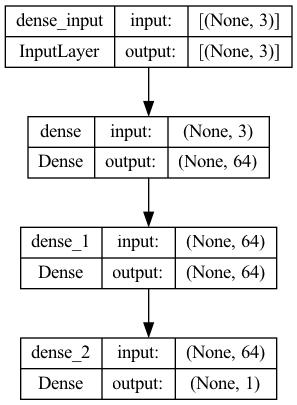

In [12]:
num_inputs = 2
model = create_model(num_inputs)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=96)

### Optimization of Inputs to Find the Best Model

* We do not know what number of inputs are optimal for the model to train on, thus we are training multiple models by specifying a range of input sizes and documenting the results so that we can find the optimized model when we do our predictions. 

In [13]:
"""
This function will help us decide how many inputs the network should have. 
This function takes the number of inputs to check the number of epochs to train for
This function will create a network, prepare data for it, then train the netowrk and evalueate its performance on the test set
"""
def select_inputs(data, start, end, epochs):
    models = {}
    for inputs in range(start, end + 1):
        print(f'Using {inputs} inputs')
        model_inputs, targets = generate_series(data, inputs)
    
        train_inputs = model_inputs[:-1000]
        val_inputs = model_inputs[-1000:]
        train_targets = targets[:-1000]
        val_targets = targets[-1000:]

        model = create_model(inputs)
        print('Training')
        model.compile(optimizer = 'adam', loss = 'mse')
        h = model.fit(train_inputs, train_targets, epochs = epochs,
                      batch_size= 32, validation_data = (val_inputs, val_targets), use_multiprocessing=True)
        model_info = {'model': model, 'history': h.history}
        models[inputs] = model_info
    return models

### Train/Validation Split

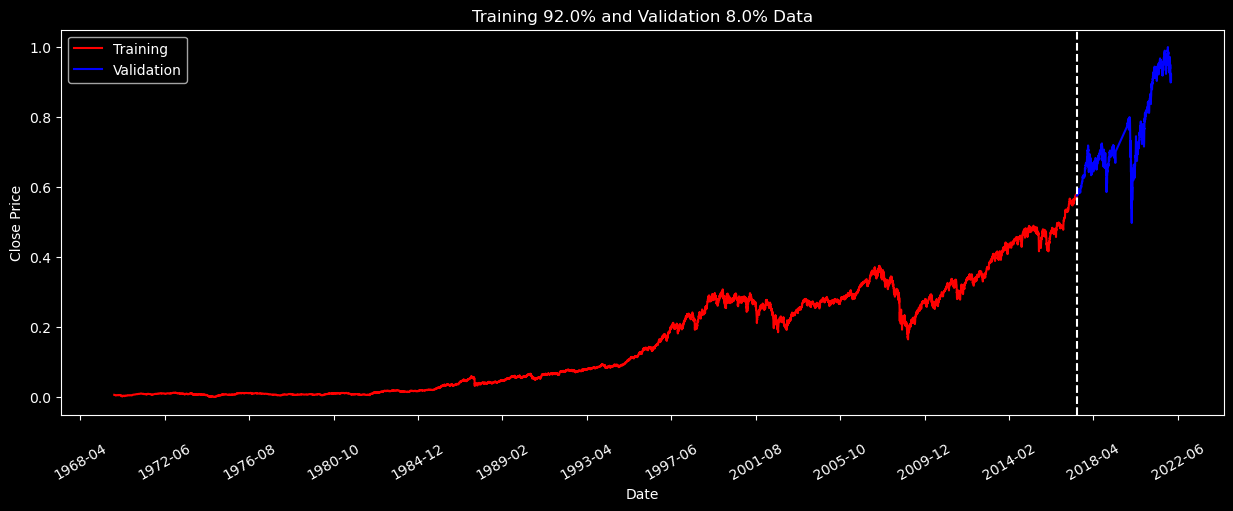

In [14]:
fig, ax = plt.subplots(figsize = (15,5))

train_percent = len(dija_history.index[:-1000]) / len(dija_history.index)
test_percent = len(dija_history.index[-1000:]) / len(dija_history.index)

ax.plot(dija_history.index[:-1000], dija_history['Close'][:-1000], 'r', label='Training')
ax.plot(dija_history.index[-1000:], dija_history['Close'][-1000:], 'b', label='Validation')
vertical_line_date = datetime.strptime('2017-07-06', '%Y-%m-%d')

ax.axvline(vertical_line_date, color='w', linestyle='--')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=50))
ax.xaxis.set_tick_params(rotation=30)
ax.xaxis.set_tick_params(which='major', pad=15)
ax.legend(loc='best')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title(f'Training {100 * round(train_percent, 2)}% and Validation {100 * round(test_percent, 2)}% Data')
plt.show()

In [15]:
# Train models on normalized data with 2,3,4,5,6,7,8,9, and 10 inputs with 20 epochs
trained_models = select_inputs(dija_history_normalized, 2, 10, 20) 

Using 2 inputs
Training
Epoch 1/20


2023-05-03 15:19:44.742474: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


375/375 [==============================] - 3s 6ms/step - loss: 4.3966e-04 - val_loss: 1.2309e-04
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 7.1798e-06 - val_loss: 1.2059e-04
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 7.4216e-06 - val_loss: 1.1757e-04
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 7.1905e-06 - val_loss: 1.1750e-04
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 7.2031e-06 - val_loss: 1.1159e-04
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 7.2378e-06 - val_loss: 1.2110e-04
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 7.1501e-06 - val_loss: 1.2199e-04
Epoch 8/20
375/375 [==============================] - 2s 5ms/step - loss: 7.7933e-06 - val_loss: 1.5688e-04
Epoch 9/20
375/375 [==============================] - 2s 6ms/step - loss: 7.9216e-06 - val_loss: 1.1371e-04
Epoch 10/20
375/375 [==================

### Model's Training Losses and Validatation Losses

* Our Loss = Mean Squared Error 

$$MSE = \frac{1}{n} \sum_{i = 1}^{n} (Y_i - Ŷ_i)^2$$

where, 

* $n$ is the number of prices
  
* $Y_i$ is the true price

* $Ŷ_i$ is the predicted price

> Our goal is to minimize this function as close to zero as possible.

During the training process of a machine learning model, the loss function is used to measure the error or the dissimilarity between the predicted output and the actual output for a given set of input data. The goal of training is to minimize this loss function, which indicates how well the model is fitting the training data.

* Our model is compiled using the `Adam` optimizer and `MSE` loss function. 

* During training, the model's weights are adjusted according to the Adam optimization algorithm.
  * The Adam optimization algorithm dynamically adapts the learning rate based on the gradient and slope of the loss function.

* The discrepancy between predicted price and actual price is measured using mean squared error.
  * MSE measures the average squared difference between true price and predicted price.

* `loss` represents the final MSE calculated on the training data.
  * This indicates how well the model is learning from the training data

* `val_loss` represents the final MSE calculated on the validation data. 
  * This indicates how well the model generalizes to new, unseen data. 

In [16]:
model_stats = {}
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss':val_loss}
model_stats

{2: {'inputs': 2,
  'loss': 7.346058737311978e-06,
  'val_loss': 0.00022658509260509163},
 3: {'inputs': 3,
  'loss': 7.417549568344839e-06,
  'val_loss': 0.00015452536172233522},
 4: {'inputs': 4,
  'loss': 9.091323590837419e-06,
  'val_loss': 0.0003702329413499683},
 5: {'inputs': 5,
  'loss': 8.258793059212621e-06,
  'val_loss': 0.00011801846994785592},
 6: {'inputs': 6,
  'loss': 7.708726116106845e-06,
  'val_loss': 0.00024358071095775813},
 7: {'inputs': 7,
  'loss': 9.602284990251064e-06,
  'val_loss': 0.00030188533128239214},
 8: {'inputs': 8,
  'loss': 9.878703167487402e-06,
  'val_loss': 0.0001767270005075261},
 9: {'inputs': 9,
  'loss': 8.620620974397752e-06,
  'val_loss': 0.00016442516061943024},
 10: {'inputs': 10,
  'loss': 8.760604941926431e-06,
  'val_loss': 0.00012640845670830458}}

### Graph of Error vs Number of Inputs For Each Model

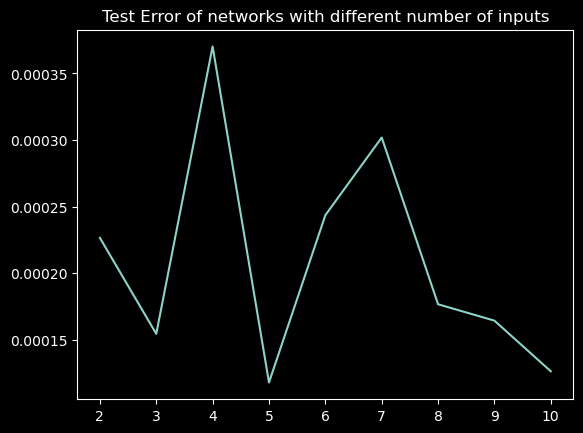

In [17]:
val_loss = []
indices = []
for k, v in model_stats.items():
    indices.append(k)
    val_loss.append(v['val_loss'])
plt.plot(indices, val_loss)
plt.title('Test Error of networks with different number of inputs')
plt.show()

### Computing Error

* Model trains on normalized data

In [18]:
# close_min = dija_history['Close'].min()
# close_max = dija_history['Close'].max()
close_min = 0
close_max = 1
for k in model_stats:
    e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
    print(k, e)

2 0.00022658509260509163
3 0.00015452536172233522
4 0.0003702329413499683
5 0.00011801846994785592
6 0.00024358071095775813
7 0.00030188533128239214
8 0.0001767270005075261
9 0.00016442516061943024
10 0.00012640845670830458


### Plot Results

Best model's optimal number of inputs = 5
406/406 [==============================] - 1s 2ms/step


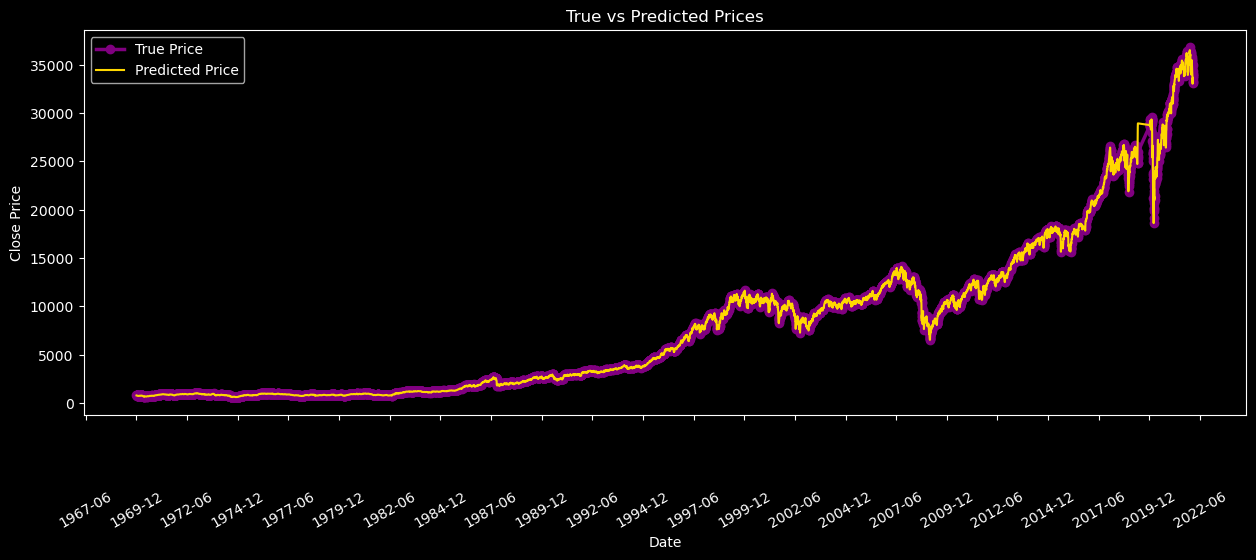

In [29]:
# Select the model with the lowest validation loss
optimal_inputs = min(model_stats, key=lambda k: model_stats[k]['val_loss'])

best_model = trained_models[optimal_inputs]['model']

val_inputs, val_targets = generate_series(dija_history_normalized, optimal_inputs)

print(f"Best model's optimal number of inputs = {optimal_inputs}")

# Generate predictions for the validation set
val_predictions = best_model.predict(val_inputs)

# Undo the normalization of the data
val_predictions = val_predictions * (h_max - h_min) + h_min
val_targets = val_targets * (h_max - h_min) + h_min

# Testing 
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(dija_history.index, dija_history['Close'], 'purple', label = 'True Price',  marker='o', linewidth=2.5)
ax.plot(dija_history.index[:-5], val_predictions, 'gold', label = 'Predicted Price')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=30))
ax.xaxis.set_tick_params(rotation=30, which = 'major', pad = 50)
ax.set_title('True vs Predicted Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()

# Plot without dates
# plt.figure(figsize =(15,5))
# plt.plot(val_targets, 'r', label='True')
# plt.plot(val_predictions, 'b', label='Predicted')
# plt.legend()
# plt.title('True vs Predicted Values')
# #plt.xlim(12960, 13000)
# plt.show()

### Error of Final Result : 

In [20]:
close_min = dija_history['Close'].min()
close_max = dija_history['Close'].max()
c_min = 0
c_max = 1
for k in model_stats:
    if (k == optimal_inputs):
        e = ((close_max - close_min) * model_stats[k]['val_loss'] + close_min)
        e_n = ((c_max - c_min) * model_stats[k]['val_loss'] + c_min)
        print(f'True Error for best model (ie: {k} inputs) = {e}')
        print(f'Normalized Error for best model (ie: {k} inputs) = {e_n}')

True Error for best model (ie: 5 inputs) = 0.00011801846994785592
Normalized Error for best model (ie: 5 inputs) = 0.00011801846994785592
